In [36]:
import serial
import serial.tools.list_ports as list_ports
import time

port_list = list(list_ports.comports())
print(port_list)
if len(port_list) == 0:
    print("无可用串口")
else:
    for i in range(len(port_list)):
        print(port_list[i])

COM3 - USB-SERIAL CH340 (COM3)


In [37]:
#---------------------------------------------------------端口基本参数------------------------------------------------------------------------
#端口
portx = "COM3"
#波特率，标准值之一：50,75,110,134,150,200,300,600,1200,
#1800,2400,4800,9600,19200,38400,57600,115200
bps = 115200
#超时设置,None：永远等待操作，0为立即返回请求结果，其他值为等待超时时间(单位为秒）
timex = 5
#bytesize,一字节长度
bs = serial.EIGHTBITS
#stopbits
sb = serial.STOPBITS_ONE
#parity
pty = serial.PARITY_NONE

#RTS/CTS
rtscts = False

#---------------------------------------------------------BLE相关参数--------------------------------------------------------------
BLE_NAME = "BLE_02"
BLE_HELLO = "HELLO WORLD!"

#工作模式
BLE_MODE_M = "M" #主模式
BLE_MODE_S = "S" #从模式
BLE_MODE_O = "O" #观察模式(不可连接,扫描广播数据)
BLE_MODE_B = "B" #广播模式(不可连接，广播用户自定义数据)
BLE_MODE_I = "I" #iBeacon(不可连接,广播特定数据,室内定位)
#发射功率
BLE_TP_N14dBm = 1 #-14dBm
BLE_TP_N11dBm = 2  #-11dBm
BLE_TP_N8dBm = 3  #-8dBm
BLE_TP_N5dBm = 4  #-5dBm
BLE_TP_N2dBm = 5  #-2dBm
BLE_TP_P2dBm = 6  #2dBm
BLE_TP_P4dBm = 7  #4dBm
BLE_TP_P8dBm = 8  #8dBm
#串口设置
BLE_UARTBPS = 115200 #50,75,110,134,150,200,300,600,1200,1800,2400,4800,9600,19200,38400,57600,115200
BLE_UARTDATE = 8     #数据位，bytesize
BLE_UARTSTOP = 1     #停止位
BLE_UARTPR = 0       #PARITY

#超时设置
TIMEX = 5

#广播速度
BLE_ADPTIM = 5  #单位：10ms

#链路匹配连接使能
BLE_LINKPASSEN = 0

#板载LED使能
BLE_LEDEN = 1

#从设备断连睡眠使能
BLE_SLAVESLPPEN = 0

#蓝牙最大输出使能
BLE_MAXPUT = 0
#----------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from socket import *
import time
#--------------------------------wifi ap相关参数----------------------------------------------------------------------------------------------
ap_tcp_serverPort = 12000


In [38]:
import threading
import tkinter as tk
import serial.tools.list_ports
from tkinter import ttk
from tkinter import scrolledtext
import re 
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np



ser = serial.Serial(timeout=5, parity=pty, bytesize=bs, stopbits=sb, rtscts=rtscts)
GUI = tk.Tk()  # 父容器


GUI.title("Serial Tool")  # 父容器标题
GUI.geometry("460x320")  # 父容器大小
GUI.resizable(width=False, height=False)
Information = tk.LabelFrame(GUI, text="操作信息", padx=10, pady=10)  # 水平，垂直方向上的边距均为10
Information.place(x=20, y=20)
Information_Window = scrolledtext.ScrolledText(Information, width=20, height=5, padx=10, pady = 10,wrap = tk.WORD)
Information_Window.grid()
 
Send = tk.LabelFrame(GUI, text="蓝牙模块BLE指令区", padx=10, pady=5)  # 水平，垂直方向上的边距均为 10
Send.place(x=260, y=20)
 
DataSend = tk.StringVar()  # 定义DataSend为保存文本框内容的字符串
 
EntrySend = tk.StringVar()
Send_Window = ttk.Entry(Send, textvariable=EntrySend, width=23)
Send_Window.grid()
 
INFO_ROWS = 1

In [39]:
def display_info(info):
    """
    info: a string info to display
    return: None
    """
    global INFO_ROWS
    Information_Window.insert("end", "%d " % (INFO_ROWS)+info+ '\n')
    INFO_ROWS += 1
    if INFO_ROWS > 10000:
        INFO_ROWS = 1
    Information_Window.see("end")

#----------------------------------------------------------BLE相关函数-------------------------------------------------------------------
#命令检查函数
def ble_cmd_check(ser, ack):
    global INFO_ROWS
    """ser: Serial object"""
    """ack: acknowledgement"""
    reply = ser.read_all().decode("utf-8")
    #显示在information window上
    display_info(reply)
    if ack in reply: 
        return True
    else:
        return False
    
#写命令函数
def ble_send_cmd(ser, cmd, ack):
    """ser: Serial object"""
    """cmd: cmd str with 'AT+'"""
    """ack: acknoledgement"""
    ser.reset_output_buffer()
    ser.reset_input_buffer()
    if ser.writable():
        ser.write((cmd+"\r\n").encode("utf-8"))
        time.sleep(0.1) #wait for 10 ms
        if ble_cmd_check(ser, ack):
            return True;
        else:
            return False
    else:
        display("串口不可写入")
    
def ble_set_init(ser):
    """SER: Serial object"""
    #进入配置模式
    while ble_send_cmd(ser, "+++a", "a+ok") == False:
        if ble_send_cmd(ser, "+++a", "ERROR") == True: #已经在配置模式
            break
        time.sleep(0.1)
    
    #AT test
    if ble_send_cmd(ser, "AT", "OK") == True:
        print("AT OK")
    
    #蓝牙名称设置
    name_cmd = "AT+NAME="+BLE_NAME
    if ble_send_cmd(ser, name_cmd, "OK") == True:
        print(name_cmd, " OK")
    else:
        print(name_cmd, " ERROR")
    
    #开机欢迎语设定
    hello_cmd = "AT+HELLO=" + BLE_HELLO
    if ble_send_cmd(ser, hello_cmd, "OK") == True:
        print(hello_cmd, " OK")
    else:
        print(hello_cmd, " ERROR") 
    
    #发射功率设置
    ble_tp = "AT+TPL=%d" % BLE_TP_P2dBm
    if ble_send_cmd(ser, ble_tp, "OK") == True:
        print(ble_tp, " OK")
    else:
        print(ble_tp, " ERROR")
        
    #串口设置
    ble_uart = "AT+UART=%d,%d,%d,%d" % (BLE_UARTBPS, BLE_UARTDATE, BLE_UARTPR, BLE_UARTSTOP)
    if ble_send_cmd(ser, ble_uart, "OK") == True:
        print(ble_uart, " OK")
    else:
        print(ble_uart, " ERROR")
    
    #广播速度设置
    ble_adptim = "AT+ADPTIM=%d" % (BLE_ADPTIM)
    if ble_send_cmd(ser, ble_adptim, "OK"):
        print(ble_adptim, " OK")
    else:
        print(ble_adptim, " ERROR")
    
    #链路匹配连接设置
    if BLE_LINKPASSEN == 1:
        if ble_send_cmd(ser, "AT+LINKPASSEN=ON", "OK"):
            print("AT+LINKPASSEN=ON", " OK")
        else:
            print("AT+LINKPASSEN=ON", " ERROR")
    else:
        if ble_send_cmd(ser, "AT+LINKPASSEN=OFF", "OK"):
            print("AT+LINKPASSEN=OFF", " OK")
        else:
            print("AT+LINKPASSEN=OFF", " ERROR")
    
    #板载LED设置
    if BLE_LEDEN == 1:
        if ble_send_cmd(ser, "AT+LEDEN=ON", "OK"):
            print("AT+LEDEN=ON", " OK")
        else:
            print("AT+LEDEN=ON", " ERROR")
    else:
        if ble_send_cmd(ser, "AT+LEDEN=OFF", "OK"):
            print("AT+LEDEN=OFF", " OK")
        else:
            print("AT+LEDEN=OFF", " ERROR")
    #从设备断连睡眠设置
    if BLE_SLAVESLPPEN == 1:
        if ble_send_cmd(ser, "AT+SLAVESLEEPEN=ON", "OK"):
            print("AT+SLAVESLEEPEN=ON", " OK")
        else:
            print("AT+SLAVESLEEPEN=ON", " ERROR")
    else:
        if ble_send_cmd(ser, "AT+SLAVESLEEPEN=OFF", "OK"):
            print("AT+SLAVESLEEPEN=OFF", " OK")
        else:
            print("AT+SLAVESLEEPEN=OFF", " ERROR")
    
    #蓝牙最大输出设置
    if BLE_MAXPUT == 1:
        if ble_send_cmd(ser, "AT+SLAVESLEEPEN=ON", "OK"):
            print("AT+SLAVESLEEPEN=ON", " OK")
        else:
            print("AT+SLAVESLEEPEN=ON", " ERROR")
    else:
        if ble_send_cmd(ser, "AT+SLAVESLEEPEN=OFF", "OK"):
            print("AT+SLAVESLEEPEN=OFF", " OK")
        else:
            print("AT+SLAVESLEEPEN=OFF", " ERROR")
    
    ble_mode = "AT+MODE=%c" % BLE_MODE_S
    if ble_send_cmd(ser, ble_mode, "OK"):
        print(ble_mode, " OK")
    else:
        print(ble_mode, " ERROR")

In [40]:


def ble_inquiry_cmd(ser, cmd):
    """
    ser: Serial object
    cmd: cmd str with 'AT+'
    """
    while ble_send_cmd(ser, "+++a", "a+ok") == False:
        if ble_send_cmd(ser, "+++a", "ERROR") == True: #已经在配置模式
            break
        time.sleep(0.1)
    ser.reset_output_buffer()
    ser.reset_input_buffer()
    if ser.writable():
        ser.write((cmd+"\r\n").encode("utf-8"))
        time.sleep(0.1) #wait for 10 ms
        reply = ser.read_all().decode("utf-8")
        #显示在信息栏上
        display_info(reply)
    else:
        return False
    
def ble_set_cmd(ser, cmd, ack):
    """
    ser: Serial object
    cmd: cmd str with 'AT+'
    ack: acknowledgement str
    """
    while ble_send_cmd(ser, "+++a", "a+ok") == False:
        if ble_send_cmd(ser, "+++a", "ERROR") == True: #已经在配置模式
            break
        time.sleep(0.1)
    if ble_send_cmd(ser, cmd, ack):
        #显示在信息栏上
        display_info("成功配置")
        return True
    else:
        #显示在信息栏上
        display_info("失败配置")
        return False

#未考虑buffer溢出的问题
#下面两函数作为范例函数
def ble_send_data(ser, data, encoding):
    """
    ser: Serial object
    data: str
    encoding: encoding format
    """
    if ser.writable():
        ser.reset_output_buffer()
        ser.write(data.encode(encoding))
    else:
        display_info("串口不可写入")
        
def ble_rece_data(ser, decoding):
    """
    ser: Serial object
    decoding: decoding format
    """
    res = ser.readline().decode(decoding)
    ser.reset_input_buffer()
    return res

#----------------------------------------------------------其他工具函数----------------------------------------------------------------------
#RGB生成函数
def hex_rgb_list(num):
    """
    num: 区间数量
    return: 一个("#000000", (0,0,0)))格式的列表
    """
    start = 0
    step = 255 // num
    res_hex = []
    res_tuple = []
    for i in range(num+1):
        temp = hex(start)[-2:].replace('x', '0')
        string = "#"+temp + temp + temp
        res_hex.append(string)
        res_tuple.append((start, start, start))
        start += step
    return (res_hex, res_tuple)



#边界生成函数
def rgbBoundarys(num, upper_bound, lower_bound):
    """
    num: 区间数量
    upper_bound:
    lower_bound:
    return: a list of length (num+1)
    """
    step = (upper_bound - lower_bound) // num
    return [upper_bound - (num-1-i)*step for i in range(num)]

#二分查找工具函数
def findBoundary(a, x):
    """
    find the first element not less than x in a (all elements in a are unique)
    a: a list
    x: target value
    return: index of the element
    """
    if x >= a[-1]:
        return len(a)-1
    res = bisect.bisect_right(a, x) # return the first element larger than x
    if res > 0 and a[res-1] == x:
        return res-1;
    return res;


#通信语句解析函数

def dataParser(data):
    """
    data: str, should match 'row+col+value'
    return: 
    return None if the format of data is wrong
    return (row, col, val)
    """
    data = data.replace("\r\n", "")
    if re.fullmatch(r'[0-9]+\+[0-9]+\+[0-9]+', data) == None:
        return None
    data_list = data.split('+')
    return (int(data_list[0]), int(data_list[1]), int(data_list[2]))



In [41]:
def WriteCmd():
    global DataSend
    cmd = EntrySend.get()
    cmd = str(cmd)
    #进行命令解析
    if re.fullmatch(r'AT\+[A-Z]*', cmd) != None: #setting cmd
        ack = "OK"
        ble_set_cmd(ser, cmd, ack)
    if re.fullmatch(r'AT\+[A-Z]*\?', cmd) != None: #inquiry cmd
        ble_inquiry_cmd(ser, cmd)

def Initialize():
    if not ser.isOpen():
        ser.port = Port_list.get()
        ser.baudrate = BaudRate_list.get()
        ser.open()
        ble_set_init(ser)
  
#----------------------------------------------------------------------------------------------------------------------------------------   
tk.Button(Send, text="初始化", command=Initialize).grid(pady=5, row = 1, sticky=tk.W)
tk.Button(Send, text="发送", command=WriteCmd).grid(pady=5, row = 1, sticky=tk.E)

Receive = tk.LabelFrame( GUI, text = "接收区", padx = 10, pady = 10 )  # 水平，垂直方向上的边距均为 10
Receive.place(x = 260, y = 124)
Receive_Window = scrolledtext.ScrolledText(Receive, width = 18, height = 9, padx = 8, pady = 10,wrap = tk.WORD)
Receive_Window.grid()
 
option = tk.LabelFrame( GUI, text = "选项", padx = 10, pady = 10 )  # 水平，垂直方向上的边距均为10
option.place(x = 20, y = 150, width = 203)  # 定位坐标
# ************创建下拉列表**************
ttk.Label( option, text = "串口号:" ).grid( column = 0, row = 0 )  # 添加串口号标签
ttk.Label( option, text = "波特率:" ).grid( column = 0, row = 1 )  # 添加波特率标签
 
Port = tk.StringVar()  # 端口号字符串
Port_list = ttk.Combobox( option, width = 12, textvariable = Port, state = 'readonly' )
ListPorts = list(serial.tools.list_ports.comports())
Port_list['values'] = [i[0] for i in ListPorts]
Port_list.current()
Port_list.grid(column=1, row=0)  # 设置其在界面中出现的位置  column代表列   row 代表行
 
BaudRate = tk.StringVar()  # 波特率字符串
BaudRate_list = ttk.Combobox( option, width = 12, textvariable = BaudRate, state = 'readonly' )
BaudRate_list['values'] = (1200, 2400, 4800, 9600, 14400, 19200, 38400, 43000, 57600, 76800, 115200)
BaudRate_list.current(10)
BaudRate_list.grid(column=1, row=1)  # 设置其在界面中出现的位置  column代表列   row 代表行
 
switch = tk.LabelFrame( GUI, text = "", padx = 10, pady = 10 )  # 水平，垂直方向上的边距均为 10
switch.place(x = 20, y = 250, width = 203)  # 定位坐标
#----------------------------------------------------------------------------------------------------------------------------------------
#色彩相关
hex_list, rgb_list = hex_rgb_list(51)
boundary_list = rgbBoundarys(51, 4096, 0)

hex_to_rgb = {}  #{hex: rgb},用于绘图
for i in range(52):
    hex_to_rgb[hex_list[i]] = rgb_list[i]

#16像素的光电探测数据画面
screen_window = tk.Toplevel(GUI)
screen_window.protocol("WM_DELETE_WINDOW", lambda : screen_window.withdraw())
screen_window.withdraw() #隐藏窗口
screen_window.geometry("360x360")
screen_window.title("光电探测画面")
screen_window.resizable(width=False, height=False)
cv = tk.Canvas(screen_window, bg="white")
cv.pack(fill=tk.BOTH, expand=tk.YES)
rects = []
xstart = 20
ystart = 20
step = 80
#行扫
for i in range(0, 4):
    for j in range(0, 4):
        rect = cv.create_rectangle(xstart, ystart, xstart+step, ystart+step, 
                                   fill=hex_list[0], outline="silver")
        rects.append(rect)
        xstart += step
    ystart += step
    xstart = 20


RECE_ROWS = 1 #接收数据的行数
FIG_INDEX = 1 #保存图片名称序号

#--------------------------------------------------------其他工具函数---------------------------------------------------------------------
def saveFig():
    global FIG_INDEX
    pixels = [[(0,0,0)] * 4 for i in range(4)]
    for i in range(16):
        fill_color = cv.itemcget(rects[i], 'fill')
        pixels[i//4][i%4] = hex_to_rgb[fill_color]
    plt.imshow(pixels)
    plt.axis('off')
    plt.savefig("fig_%d.png" % FIG_INDEX, dpi=200, bbox_inches="tight", pad_inches=0)
    FIG_INDEX += 1
    
def ReceiveData():
    global RECE_ROWS
    while ser.isOpen():
        #按行读数据
        res = ser.readline()
        try:  
            res = res.decode("utf-8")
        except: #遭遇非UTF-8字符
            continue
        Receive_Window.insert("end",  "%d " % (RECE_ROWS)+res+ '\n')
        RECE_ROWS += 1
        if RECE_ROWS > 10000:
            RECE_ROWS = 1
        Receive_Window.see("end")
        data = dataParser(res)
        if data != None:
            row, col, val = data
            if row >= 4 or col >= 4 or row < 0 or col < 0:
                continue
            val_index = findBoundary(boundary_list, val)
            color = hex_list[val_index]
            cv.itemconfig(rects[4*row+col], fill=color)
        else:
            display_info("失败读取")

IS_SERIAL_THREAD_ON = False            

def Close_Serial(ser):
    global IS_SERIAL_THREAD_ON
    #显示模块
    display_info("串口已关闭") 
    
    IS_SERIAL_THREAD_ON = False
    ser.close()
        
def Open_Serial():
    if not ser.isOpen():
        ser.port = Port_list.get()
        ser.baudrate = BaudRate_list.get()
        try:
            ser.open()
        except:
            display_info("当前无可用串口")
    global IS_SERIAL_THREAD_ON
    if ser.isOpen() and IS_SERIAL_THREAD_ON == False:
        screen_window.deiconify() #显示窗口
        t = threading.Thread(target=ReceiveData)
        IS_SERIAL_THREAD_ON = True
        
        display_info("串口已开启")
        
        t.setDaemon(True)
        t.start()
    if ser.isOpen() and IS_SERIAL_THREAD_ON == True:
        screen_window.deiconify() #显示窗口
        
        
#----------------------------------------------------------------------------------------------------------------------------------------        
tk.Button( switch, text = "开始采集", command = Open_Serial ).grid(row = 0, column= 0, padx = 1)
tk.Button( switch, text = "停止采集", command = lambda: Close_Serial(ser) ).grid(row = 0, column=1, padx = 1)
tk.Button(switch, text="保存图片", command = saveFig).grid(row = 0, column = 2, padx = 1)

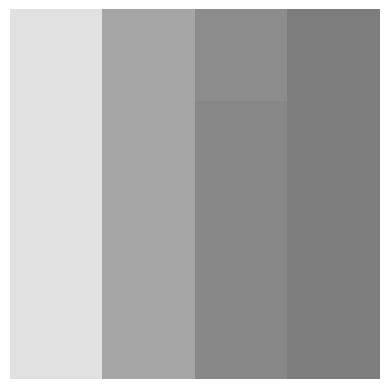

In [42]:
GUI.mainloop()